In [13]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.quantum_info import SparsePauliOp

from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator

from qiskit_ibm_runtime.fake_provider import FakeFez

#import warnings
#warnings.filterwarnings('ignore', category=UserWarning, module='qiskit_ibm_runtime.fake_provider.local_service')

### 1. Use Qiskit Runtime to access real IBM device or use a Fake Backend

In [2]:
service = QiskitRuntimeService()

backend = FakeFez()
backend.name

management.get:WARNING:2025-11-18 15:51:15,304: Loading default saved account


'fake_fez'

In [ ]:
#QiskitRuntimeService.save_account(channel='ibm_quantum_platform', instance = '', token='', overwrite=True, set_as_default=True)
#service = QiskitRuntimeService(channel='ibm_quantum_platform')

#backend = service.least_busy(operational=True, simulator=False)
## backend = service.backend('ibm_kingston')  # Example for a specific backend
#backend.name

management.get:WARNING:2025-11-12 12:14:53,808: Loading default saved account


'ibm_kingston'

### 2. Choose system size and depth of ansatz. 
Then load the corresponding pre-optimized parameters (obtained from MPS simulations)

In [3]:
N = 14; J = 1.0; h = 1.0
chosen_depth = 4

In [ ]:
data_from_sim = np.load(f'optimized_params/experiment_params_N{N}_trotter{chosen_depth}.npz')

depth = data_from_sim['depthKE']
zeta = data_from_sim['best_zeta']
opt_params_from_sim = data_from_sim['params_vqeKE']
opt_energy_from_sim = data_from_sim['energy_vqeKE']
fidelity_from_sim = data_from_sim['fidelity_vqeKE']
gate_count = data_from_sim['gate_count_KE']

print("Energy for ground state prep circuit without noise", opt_energy_from_sim)

Energy for ground state prep circuit without noise -1.2220393543750816


### 3. Choosing a connected chain of desired length from hardware

In [7]:
coupling_map = backend.target.build_coupling_map()

def _adjacency(cm: CouplingMap, require_bidir: bool = False):
    """Undirected adjacency; if require_bidir=True keep only bidirectional CX edges."""
    edges = set(cm.get_edges())
    adj = {q: set() for q in cm.physical_qubits}
    for u, v in edges:
        if require_bidir and (v, u) not in edges:
            continue
        adj[u].add(v); adj[v].add(u)
    # drop isolated vertices (rare)
    return {q: nbs for q, nbs in adj.items() if nbs}

def find_open_chain(cm: CouplingMap, N: int, require_bidir: bool = False):
    """
    Find any simple path of N nodes (length N-1). Returns list of physical qubits or None.
    Also returns the longest path seen if exact N is impossible.
    """
    adj = _adjacency(cm, require_bidir=require_bidir)
    if N <= 1:
        # trivial
        for q in adj: 
            return [q], [q]
    # Prefer starting from degree-1 endpoints (good for chains), else all nodes
    endpoints = [q for q, nbs in adj.items() if len(nbs) == 1]
    starts = endpoints if endpoints else list(adj)

    best = []
    target = N

    # DFS with simple pruning
    for s in starts:
        stack = [(s, [s])]
        seen_starts = set()
        while stack:
            node, path = stack.pop()
            if len(path) > len(best):
                best = path
                if len(best) == target:  # found exact length
                    return best, best
            # Heuristic: expand neighbors with higher degree first
            nexts = sorted(adj[node] - set(path), key=lambda x: len(adj[x]), reverse=True)
            for nb in nexts:
                # Upper bound pruning: if even extending by all unused neighbors cannot reach target, skip
                if len(path) + (len(adj[nb]) or 1) < min(target, len(cm.physical_qubits)):
                    pass  # optional; keep simple
                stack.append((nb, path + [nb]))
        seen_starts.add(s)

    # No exact N found
    return None, best


chain, best = find_open_chain(coupling_map, N, require_bidir=False)

if chain is None:
    print(f"No {N}-qubit open chain found on {backend.name}. Longest found has {len(best)} qubits:", best)
    print(f"Cannot proceed with N={N}. Please choose a different N or backend.")
else:
    print(f"Successfully found {N}-qubit physical chain: {chain}")

Successfully found 14-qubit physical chain: [0, 1, 2, 3, 4, 5, 6, 7, 17, 27, 28, 29, 30, 31]


### 4. Build ansatz on the chosen chain
The hardware efficient ansatz uses only parametrized 1 qubit rotations, and the native 2 qubit gate of the hardware 
(which for IBM's Heron processors is Cz)

In [10]:
def hardware_efficient_ansatz(N, trotter_steps, A, zeta):

    circuit = QuantumCircuit(N)
    params = ParameterVector("θ", 2 * N * trotter_steps)
    
    # Initialize in |+> state
    for i in range(N):
        circuit.h(i)
    #circuit.barrier()

    # constructing variational circuit
    idx = 0
    for layer in range(trotter_steps):
        
        # H1 layer
        for i in range(N):
            circuit.rx(2*params[idx],i)
            idx += 1
            circuit.rz(2*params[idx],i)
            idx += 1

        # H2 layer
        if layer != trotter_steps - 1:
            # H2 layers - This is now a Cz layer
            for i in range(int(N/2)):
                circuit.cz(2*i,2*i+1)
            for i in range(int((N-1)/2)):
                circuit.cz(2*(i+1)-1,2*(i+1))

        #circuit.barrier()

        # Kinetic term layer
        ke_angle = A*np.exp(-zeta*layer)
        if layer != trotter_steps - 1 and ke_angle > 1e-3:  # Avoid applying at the last layer and if angle is too small
            for i in range(N):
                circuit.ry(2*ke_angle,i)
            #circuit.barrier()
    
    return circuit, params

ansatz_hardware_efficient, params = hardware_efficient_ansatz(N, trotter_steps=chosen_depth, A=np.pi/2, zeta=zeta) 
#ansatz_hardware_efficient.draw("mpl", scale=0.6, style="iqp", fold=-1, idle_wires=False)

### 5. Transpile circuit for chosen hardware

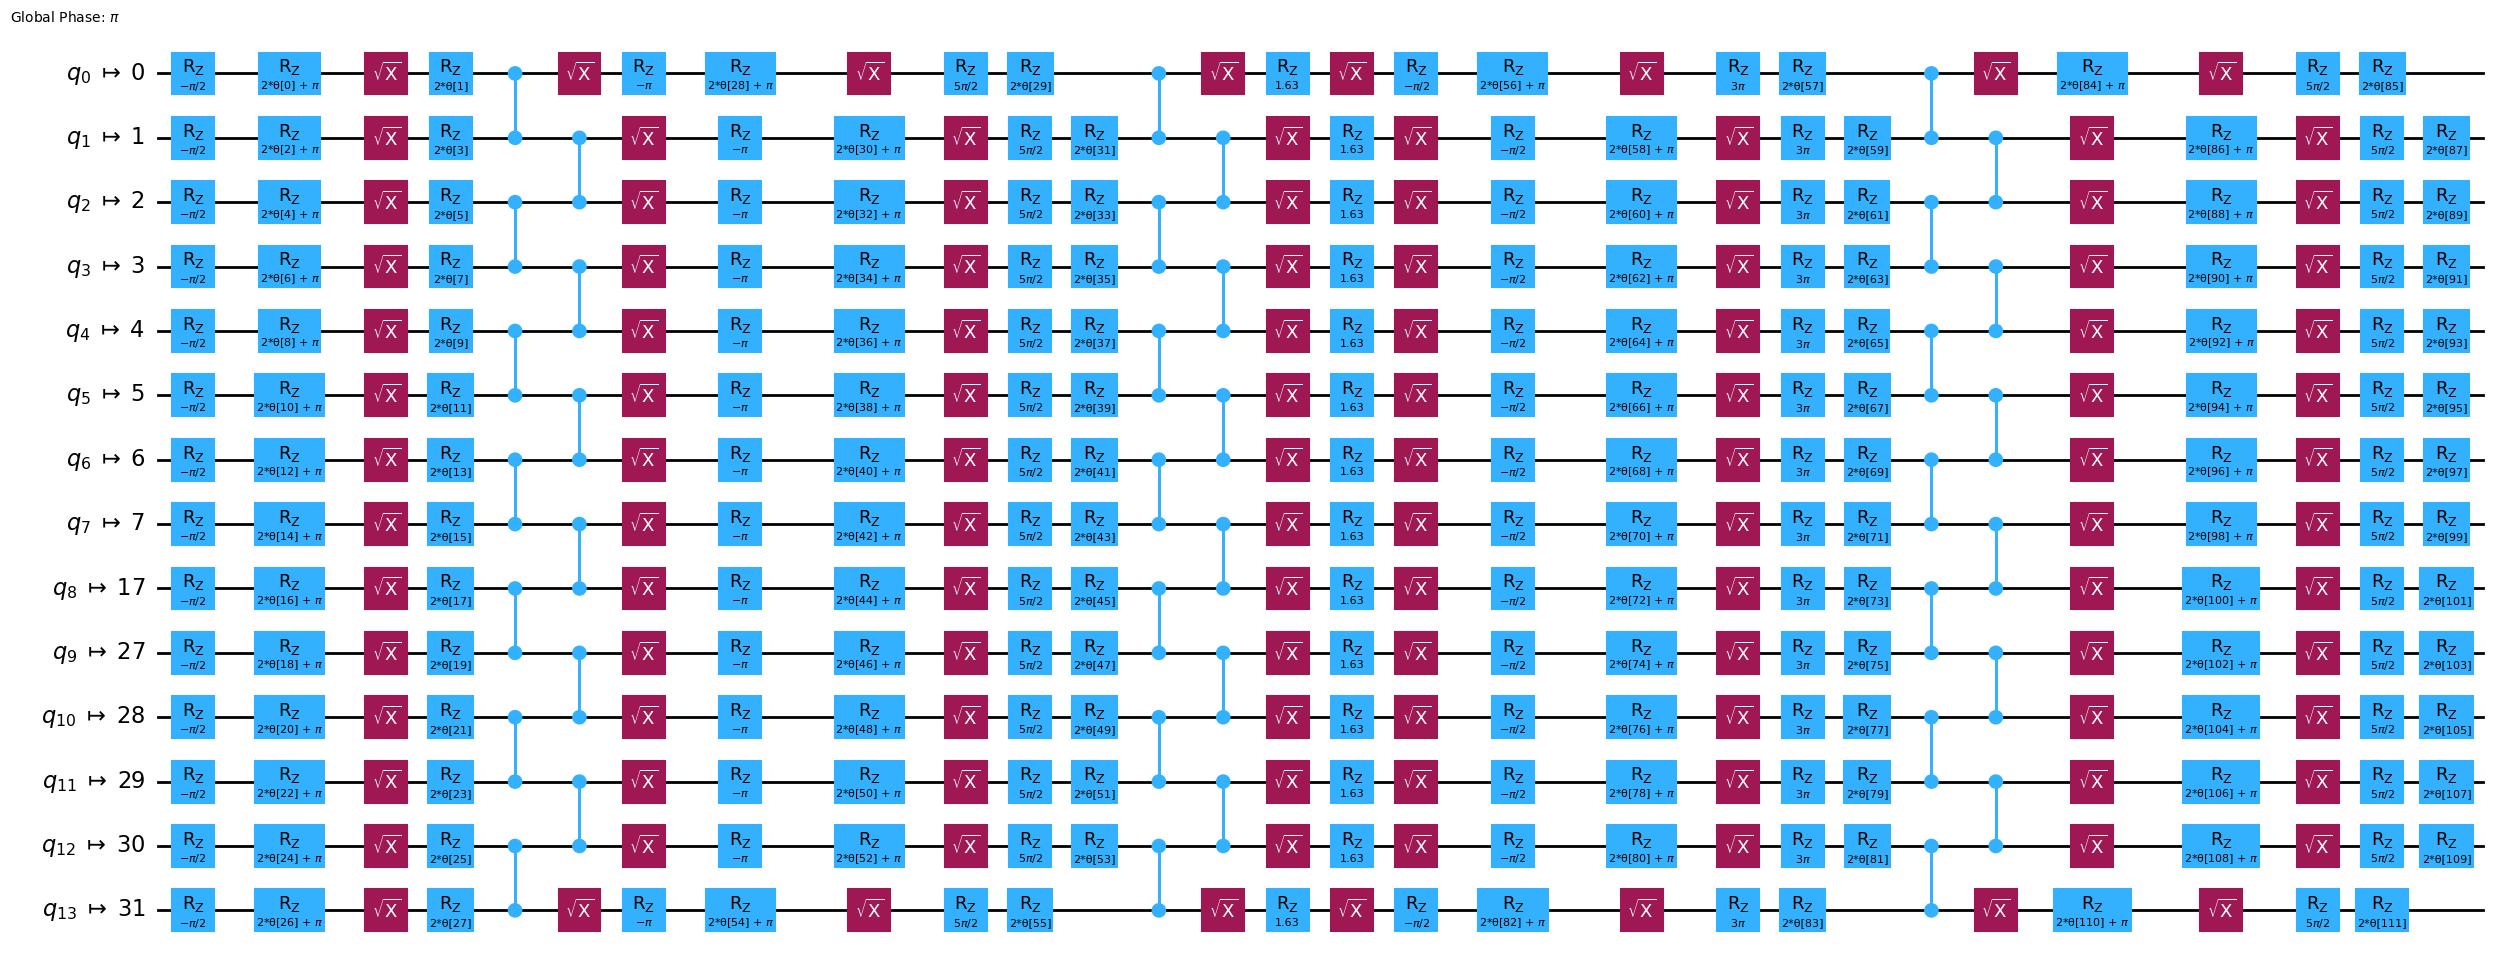

In [14]:
ansatz_ibm = transpile(
    ansatz_hardware_efficient, 
    backend=backend, 
    initial_layout=chain,
    optimization_level=3,
    scheduling_method=None 
)

ansatz_ibm.draw('mpl', fold=-1, idle_wires=False)

### 5. Define the measurement observable - the target Hamiltonian

In [15]:
def build_physical_hamiltonian_on_chain(
    physical_chain: list[int], 
    total_device_qubits: int, 
    J: float = 1.0, 
    h: float = 1.0
) -> SparsePauliOp:
    """
    Builds the TFIM Hamiltonian SparsePauliOp directly on the
    specified physical qubits.
    
    Args:
        physical_chain: The list of physical qubit indices (e.g., [4, 7, 10]).
        total_device_qubits: The total number of qubits on the backend (e.g., 127).
        J: ZZ coupling strength.
        h: X field strength.
    """
    terms = []
    
    # Add ZZ terms for adjacent qubits in the physical chain
    for i in range(len(physical_chain) - 1):
        q1 = physical_chain[i]
        q2 = physical_chain[i+1]
        # Build the term on the physical qubit indices
        terms.append(('ZZ', [q1, q2], -J))
             
    # Add X terms for ALL qubits in the physical chain
    for q in physical_chain:
        # Build the term on the physical qubit index
        terms.append(('X', [q], -h))
        
    # Create the operator defined over the full device
    return SparsePauliOp.from_sparse_list(terms, num_qubits=total_device_qubits)

In [16]:
# Get the total number of qubits on the backend
total_qubits = backend.target.num_qubits

# Build the observable. This is our final, physical observable.
observable_ibm = build_physical_hamiltonian_on_chain(
    physical_chain=chain, 
    total_device_qubits =total_qubits, 
    J=J, 
    h=h
)

### 6. Calculate expectation value in the prepared ground state!

In [ ]:
with Session(backend=backend) as session:
    estimator = Estimator()
    estimator.options.default_shots = 4000

    energy_noisy = estimator.run([(ansatz_ibm, observable_ibm, [opt_params_from_sim])]).result()[0].data.evs[0]
    print(f"Estimated energy on {backend.name}: {energy_noisy/N:.6f}")